In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv, GINConv, GATConv  # noqa
from torch_geometric.utils import train_test_split_edges
import argparse
import numpy as np
import random
import os
from sklearn.metrics import roc_auc_score, f1_score
import json
from torch.nn import Sequential, ReLU, Linear

torch.autograd.set_detect_anomaly(True)

class GradReverse(torch.autograd.Function):
    """
    Implement the gradient reversal layer for the convenience of domain adaptation neural network.
    The forward part is the identity function while the backward part is the negative function.
    """
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, inputs):
        return GradReverse.apply(inputs)

In [6]:
def sim(lambda_reg):
    class Net(torch.nn.Module):
        def __init__(self, name='GCNConv'):
            super(Net, self).__init__()
            self.name = name
            if (name == 'GCNConv'):
                self.conv1 = GCNConv(dataset.num_features, 128)
                self.conv2 = GCNConv(128, 64)
            elif (name == 'ChebConv'):
                self.conv1 = ChebConv(dataset.num_features, 128, K=2)
                self.conv2 = ChebConv(128, 64, K=2)
            elif (name == 'GATConv'):
                self.conv1 = GATConv(dataset.num_features, 128)
                self.conv2 = GATConv(128, 64)
            elif (name == 'GINConv'):
                nn1 = Sequential(Linear(dataset.num_features, 128), ReLU(), Linear(128, 64))
                self.conv1 = GINConv(nn1)
                self.bn1 = torch.nn.BatchNorm1d(64)
                nn2 = Sequential(Linear(64, 64), ReLU(), Linear(64, 64))
                self.conv2 = GINConv(nn2)
                self.bn2 = torch.nn.BatchNorm1d(64)

            self.attr = GCNConv(64, dataset.num_classes, cached=True,
                                    normalize=not gdc)

            self.attack = GCNConv(64, dataset.num_classes, cached=True,
                                normalize=not gdc)
            self.reverse = GradientReversalLayer()

        def forward(self, pos_edge_index, neg_edge_index):

            if (self.name == 'GINConv'):
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.bn1(x)
                x = F.relu(self.conv2(x, data.train_pos_edge_index))
                x = self.bn2(x)
            else:
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.conv2(x, data.train_pos_edge_index)

            feat = x
            attr = self.attr(x, edge_index, edge_weight)

            #print(feat.size())
            attack = self.reverse(x)
            att = self.attack(attack, edge_index, edge_weight)

            total_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
            x_j = torch.index_select(x, 0, total_edge_index[0])
            x_i = torch.index_select(x, 0, total_edge_index[1])

            """
            print(x_j.size())
            print(x_i.size())
            """

            res = torch.einsum("ef,ef->e", x_i, x_j)

            #print(res.size())
            return res, F.log_softmax(attr, dim=1), F.log_softmax(att, dim=1), feat
    
    m = 'GCNConv' 
    seed = 42
    lr = 0.01
    num_epochs = 250
    finetune_epochs = 40
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

    dataset = "Cora"
    path = osp.join('..', 'data', dataset)
    dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
    data = dataset[0]
    gdc = False
    if gdc:
        gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
                    normalization_out='col',
                    diffusion_kwargs=dict(method='ppr', alpha=0.05),
                    sparsification_kwargs=dict(method='topk', k=128,
                                            dim=0), exact=True)
        data = gdc(data)

    labels = data.y.cuda()
    edge_index, edge_weight = data.edge_index.cuda(), data.edge_attr

    print(labels.size())
    # Train/validation/test
    data = train_test_split_edges(data)

    print(labels)

    device = torch.device('cuda')
    model, data = Net(m).cuda(), data.to("cuda")

    if (m=='GINConv'):
        optimizer = torch.optim.Adam([
            dict(params=model.conv1.parameters(), weight_decay=0),
            dict(params=model.bn1.parameters(), weight_decay=0),
            dict(params=model.conv2.parameters(), weight_decay=0),
            dict(params=model.bn2.parameters(), weight_decay=0),
        ], lr=lr)
    else:
        optimizer = torch.optim.Adam([
            dict(params=model.conv1.parameters(), weight_decay=0),
            dict(params=model.conv2.parameters(), weight_decay=0)
        ], lr=lr)

    if (m=='GINConv'):
        optimizer_att = torch.optim.Adam([
            dict(params=model.conv2.parameters(), weight_decay=5e-4), 
            dict(params=model.bn2.parameters(), weight_decay=0),  
            dict(params=model.attack.parameters(), weight_decay=5e-4),
        ], lr=lr * lambda_reg)
    else:
        optimizer_att = torch.optim.Adam([
            dict(params=model.conv2.parameters(), weight_decay=5e-4),   
            dict(params=model.attack.parameters(), weight_decay=5e-4),
        ], lr=lr * lambda_reg)

    def get_link_labels(pos_edge_index, neg_edge_index):
        link_labels = torch.zeros(pos_edge_index.size(1) +
                                neg_edge_index.size(1)).float().to(device)
        link_labels[:pos_edge_index.size(1)] = 1.
        return link_labels

    global switch
    switch = True
    
    def train():
        global switch
        model.train()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        link_logits, attr_prediction, attack_prediction,_ = model(pos_edge_index, neg_edge_index)
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)

        loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
        loss2 = F.nll_loss(attack_prediction, labels)
        
        if switch:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            switch = False
        else:
            optimizer_att.zero_grad()
            loss2.backward()
            optimizer_att.step()
            switch = True

        return loss


    def test():
        model.eval()
        perfs = []
        for prefix in ["val", "test"]:
            pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(prefix),
                                        "{}_neg_edge_index".format(prefix))
            ]
            link_probs = torch.sigmoid(model(pos_edge_index, neg_edge_index)[0])
            link_labels = get_link_labels(pos_edge_index, neg_edge_index)
            link_probs = link_probs.detach().cpu().numpy()
            link_labels = link_labels.detach().cpu().numpy()
            perfs.append(roc_auc_score(link_labels, link_probs))
        return perfs


    best_val_perf = test_perf = 0
    for epoch in range(1, num_epochs+1):
        train_loss = train()
        val_perf, tmp_test_perf = test()
        if val_perf > best_val_perf:
            best_val_perf = val_perf
            test_perf = tmp_test_perf
        log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        print(log.format(epoch, train_loss, val_perf, tmp_test_perf))


    optimizer_attr = torch.optim.Adam([
        dict(params=model.attr.parameters(), weight_decay=5e-4),
    ], lr=lr)

    def train_attr():
        model.train()
        optimizer_attr.zero_grad()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        F.nll_loss(model(pos_edge_index, neg_edge_index)[1][data.train_mask], labels[data.train_mask]).backward()
        optimizer_attr.step()


    @torch.no_grad()
    def test_attr():
        model.eval()
        accs = []
        m = ['train_mask', 'val_mask', 'test_mask']
        i = 0
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):

            if (m[i] == 'train_mask') :
                x, pos_edge_index = data.x, data.train_pos_edge_index

                _edge_index, _ = remove_self_loops(pos_edge_index)
                pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                                num_nodes=x.size(0))

                neg_edge_index = negative_sampling(
                    edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
                    num_neg_samples=pos_edge_index.size(1))
            else:
                pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(m[i].split("_")[0]),
                                        "{}_neg_edge_index".format(m[i].split("_")[0]))
                ]
            _, logits, _, _ = model(pos_edge_index, neg_edge_index)

            pred = logits[mask].max(1)[1]
            #acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            #accs.append(acc)

            macro = f1_score((data.y[mask]).cpu().numpy(), pred.cpu().numpy(),average='macro')
            accs.append(macro)

            i+=1
        return accs

    if True:
        best_val_acc = test_acc = 0
        for epoch in range(1, finetune_epochs+1):
            train_attr()
            train_acc, val_acc, tmp_test_acc = test_attr()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                test_acc = tmp_test_acc
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            #print(log.format(epoch, train_acc, val_acc, tmp_test_acc))
    return model

In [25]:
L1 = 1
L2 = 1
L3 = 0

model_135 = sim(L1)
print("=====================")
model_0 = sim(L3)

torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3], device='cuda:0')
Epoch: 001, Loss: 0.6632, Val: 0.7074, Test: 0.7064
Epoch: 002, Loss: 2.1086, Val: 0.6920, Test: 0.6882
Epoch: 003, Loss: 3.2634, Val: 0.7742, Test: 0.7527
Epoch: 004, Loss: 0.6629, Val: 0.7364, Test: 0.7220
Epoch: 005, Loss: 0.8540, Val: 0.6544, Test: 0.6336
Epoch: 006, Loss: 0.8155, Val: 0.6527, Test: 0.6322
Epoch: 007, Loss: 0.8992, Val: 0.6587, Test: 0.6396
Epoch: 008, Loss: 0.7203, Val: 0.6528, Test: 0.6326
Epoch: 009, Loss: 0.7615, Val: 0.6802, Test: 0.6622
Epoch: 010, Loss: 0.6770, Val: 0.6663, Test: 0.6472
Epoch: 011, Loss: 0.6963, Val: 0.6943, Test: 0.6817
Epoch: 012, Loss: 0.6741, Val: 0.6792, Test: 0.6650
Epoch: 013, Loss: 0.6845, Val: 0.6974, Test: 0.6855
Epoch: 014, Loss: 0.6765, Val: 0.6844, Test: 0.6723
Epoch: 015, Loss: 0.6861, Val: 0.6951, Test: 0.6868
Epoch: 016, Loss: 0.6800, Val: 0.6869, Test: 0.6756
Epoch: 017, Loss: 0.6896, Val: 0.6924, Test: 0.6897
Epoch: 018, Loss: 0.6833, Val: 0.6863, Test: 0.

Epoch: 161, Loss: 0.7378, Val: 0.8049, Test: 0.8384
Epoch: 162, Loss: 0.6681, Val: 0.8053, Test: 0.8382
Epoch: 163, Loss: 0.7305, Val: 0.8060, Test: 0.8416
Epoch: 164, Loss: 0.6737, Val: 0.8059, Test: 0.8408
Epoch: 165, Loss: 0.7490, Val: 0.8071, Test: 0.8441
Epoch: 166, Loss: 0.6777, Val: 0.8084, Test: 0.8431
Epoch: 167, Loss: 0.7506, Val: 0.8064, Test: 0.8473
Epoch: 168, Loss: 0.6672, Val: 0.8083, Test: 0.8466
Epoch: 169, Loss: 0.7348, Val: 0.8091, Test: 0.8472
Epoch: 170, Loss: 0.6628, Val: 0.8104, Test: 0.8457
Epoch: 171, Loss: 0.7300, Val: 0.8194, Test: 0.8471
Epoch: 172, Loss: 0.6490, Val: 0.8191, Test: 0.8444
Epoch: 173, Loss: 0.7017, Val: 0.8237, Test: 0.8448
Epoch: 174, Loss: 0.6460, Val: 0.8222, Test: 0.8418
Epoch: 175, Loss: 0.6765, Val: 0.8197, Test: 0.8206
Epoch: 176, Loss: 0.6268, Val: 0.8184, Test: 0.8181
Epoch: 177, Loss: 0.6727, Val: 0.8211, Test: 0.8222
Epoch: 178, Loss: 0.6122, Val: 0.8172, Test: 0.8182
Epoch: 179, Loss: 0.6270, Val: 0.8066, Test: 0.8119
Epoch: 180, 

Epoch: 071, Loss: 0.4906, Val: 0.8755, Test: 0.8722
Epoch: 072, Loss: 0.4916, Val: 0.8755, Test: 0.8722
Epoch: 073, Loss: 0.4899, Val: 0.8776, Test: 0.8775
Epoch: 074, Loss: 0.4765, Val: 0.8776, Test: 0.8775
Epoch: 075, Loss: 0.4827, Val: 0.8799, Test: 0.8821
Epoch: 076, Loss: 0.4786, Val: 0.8799, Test: 0.8821
Epoch: 077, Loss: 0.4816, Val: 0.8813, Test: 0.8862
Epoch: 078, Loss: 0.4795, Val: 0.8813, Test: 0.8862
Epoch: 079, Loss: 0.4761, Val: 0.8827, Test: 0.8889
Epoch: 080, Loss: 0.4749, Val: 0.8827, Test: 0.8889
Epoch: 081, Loss: 0.4804, Val: 0.8843, Test: 0.8906
Epoch: 082, Loss: 0.4793, Val: 0.8843, Test: 0.8906
Epoch: 083, Loss: 0.4743, Val: 0.8856, Test: 0.8915
Epoch: 084, Loss: 0.4706, Val: 0.8856, Test: 0.8915
Epoch: 085, Loss: 0.4691, Val: 0.8870, Test: 0.8918
Epoch: 086, Loss: 0.4715, Val: 0.8870, Test: 0.8918
Epoch: 087, Loss: 0.4708, Val: 0.8879, Test: 0.8919
Epoch: 088, Loss: 0.4664, Val: 0.8879, Test: 0.8919
Epoch: 089, Loss: 0.4679, Val: 0.8889, Test: 0.8925
Epoch: 090, 

Epoch: 231, Loss: 0.4080, Val: 0.9181, Test: 0.9131
Epoch: 232, Loss: 0.4130, Val: 0.9181, Test: 0.9131
Epoch: 233, Loss: 0.4145, Val: 0.9179, Test: 0.9128
Epoch: 234, Loss: 0.4096, Val: 0.9179, Test: 0.9128
Epoch: 235, Loss: 0.4035, Val: 0.9179, Test: 0.9125
Epoch: 236, Loss: 0.4116, Val: 0.9179, Test: 0.9125
Epoch: 237, Loss: 0.4097, Val: 0.9178, Test: 0.9122
Epoch: 238, Loss: 0.4158, Val: 0.9178, Test: 0.9122
Epoch: 239, Loss: 0.4082, Val: 0.9181, Test: 0.9120
Epoch: 240, Loss: 0.4074, Val: 0.9181, Test: 0.9120
Epoch: 241, Loss: 0.4038, Val: 0.9174, Test: 0.9118
Epoch: 242, Loss: 0.4122, Val: 0.9174, Test: 0.9118
Epoch: 243, Loss: 0.4069, Val: 0.9171, Test: 0.9114
Epoch: 244, Loss: 0.4066, Val: 0.9171, Test: 0.9114
Epoch: 245, Loss: 0.4025, Val: 0.9174, Test: 0.9113
Epoch: 246, Loss: 0.4139, Val: 0.9174, Test: 0.9113
Epoch: 247, Loss: 0.4093, Val: 0.9171, Test: 0.9104
Epoch: 248, Loss: 0.4034, Val: 0.9171, Test: 0.9104
Epoch: 249, Loss: 0.4105, Val: 0.9171, Test: 0.9106
Epoch: 250, 

In [16]:
def feat(model):
    model.train()
    
    dataset = "Cora"
    path = osp.join('..', 'data', dataset)
    dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
    data = dataset[0]
    gdc = False
    if gdc:
        gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
                    normalization_out='col',
                    diffusion_kwargs=dict(method='ppr', alpha=0.05),
                    sparsification_kwargs=dict(method='topk', k=128,
                                            dim=0), exact=True)
        data = gdc(data)

    labels = data.y.cuda()
    edge_index, edge_weight = data.edge_index.cuda(), data.edge_attr

    print(labels.size())
    # Train/validation/test
    data = train_test_split_edges(data)
    
    x, pos_edge_index = data.x, data.train_pos_edge_index

    _edge_index, _ = remove_self_loops(pos_edge_index)
    pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                    num_nodes=x.size(0))

    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
        num_neg_samples=pos_edge_index.size(1))

    return model(pos_edge_index.cuda(), neg_edge_index.cuda())[-1]

In [17]:
feat0 = feat(model_0)
#feat1 = feat(model_1)
feat135 = feat(model_135)

torch.Size([2708])
torch.Size([2708])


In [18]:
dataset = "Cora"
path = osp.join('..', 'data', dataset)
dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
data = dataset[0]
labels = data.y.detach().cpu().numpy()

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1500)
tsne_0 = tsne.fit_transform(feat0.cpu().detach().numpy())
#tsne_1 = tsne.fit_transform(feat1.cpu().detach().numpy())
tsne_135 = tsne.fit_transform(feat135.cpu().detach().numpy())

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.000s...
[t-SNE] Computed neighbors for 2708 samples in 0.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 1.002105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.045853
[t-SNE] KL divergence after 1500 iterations: 0.851933
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.000s...
[t-SNE] Computed neighbors for 2708 samples in 0.297s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.694124
[t-SNE] KL divergence after 50 iterations with early exaggeration: 59.706398
[t-SNE] KL divergence after 1500 iterations: 0.644976

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("dark")
sns.set(rc={'figure.figsize':(8,8)})
palette = sns.color_palette("bright", 7)
ax = sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=lab.detach().cpu().numpy(), legend='full', palette=palette)
ax.grid(False)
ax.patch.set_facecolor('white')
ax.set_axis_off()

In [20]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [21]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
dataset = "Cora"
path = osp.join('..', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]
el = data.edge_index.cpu().numpy()
G = nx.Graph([(el[0,i],el[1,i]) for i in range(el.shape[1])])

In [22]:
pos0 = {}
for i in range(2708):
    pos0[i]=[tsne_0[i,0],tsne_0[i,1]]
    
pos135 = {}
for i in range(2708):
    pos135[i]=[tsne_135[i,0],tsne_135[i,1]]

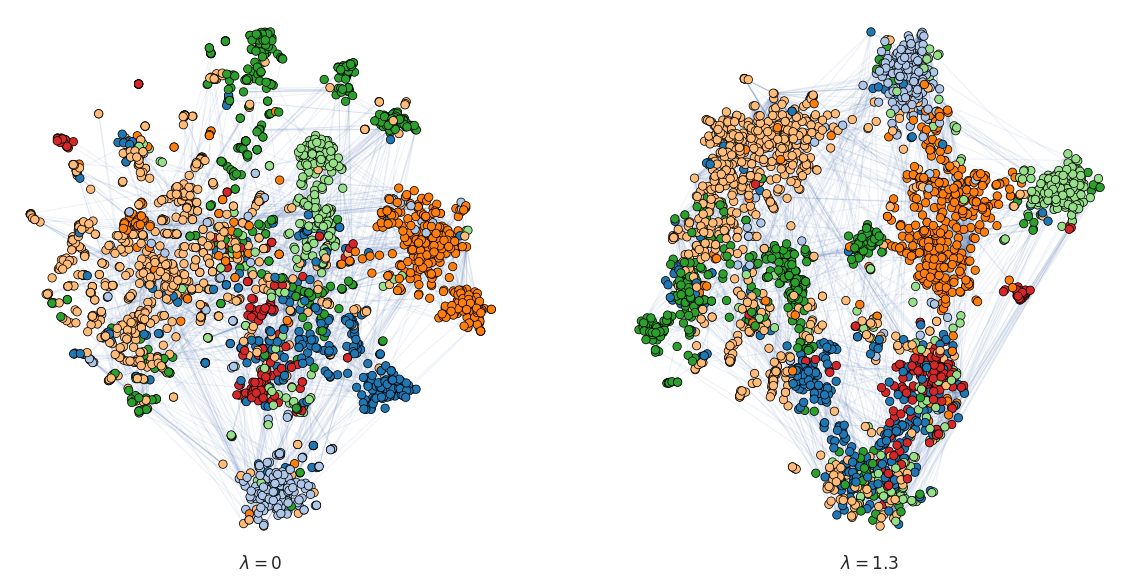

In [23]:
sns.set(rc={'figure.figsize':(20,10)})

fig, axs = plt.subplots(ncols=2)

palette = sns.color_palette("tab20",7)
nx.draw_networkx_edges(G, pos0, alpha=0.1,edge_color='b',style='solid',ax=axs[0])
sns.scatterplot(tsne_0[:,0], tsne_0[:,1], hue=labels, legend=None, palette=palette,ax=axs[0],s=70, edgecolor="black")

axs[0].grid(False)
axs[0].patch.set_facecolor('white')
axs[0].set(xticks=[],yticks=[])
axs[0].set_xlabel(r'$\lambda = 0$', fontsize=17)

nx.draw_networkx_edges(G, pos135, alpha=0.1,edge_color='b',style='solid',ax=axs[1])
sns.scatterplot(tsne_135[:,0], tsne_135[:,1], hue=labels, legend=None, palette=palette,ax=axs[1],s=70, edgecolor="black")

axs[1].grid(False)
axs[1].patch.set_facecolor('white')
axs[1].set(xticks=[],yticks=[])
axs[1].set_xlabel(r'$\lambda = 1.3$', fontsize=17)

plt.show()

fig.savefig('cora.pdf', bbox_inches='tight') 